<a href="https://colab.research.google.com/github/jmcajigas/PDS/blob/main/Taller_jcajigas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install openbci-stream

In [ ]:
%%capture
from openbci_stream.utils import HDF5Reader
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargar las series de tiempo de achivo H5.

In [ ]:
filename = '/content/drive/Shareddrives/DSP/Notebooks/Adquisición señales/record-10_19_22-10_27_02.h5'
with HDF5Reader(filename) as reader:
    reader.header['channels_by_board'] = [8]
    data = reader.eeg[:7]
    sample_rate = reader.header['sample_rate']
    markers = reader.markers
    timestamp = reader.timestamp[0]

```data``` contiene la señal en la forma ```(canales, tiempo)```, ```sample_rate```es la frecuencia de muestreo en Hz.

In [ ]:
f'{data.shape[0]} canales, {data.shape[1]/sample_rate} segundos, {sample_rate} Hz'

'7 canales, 171.1 segundos, 1000 Hz'

# Procesamiento

## Inspección base

Graficamos todos los canales y sus marcadores, para detectar errores en la captura (los pocos que se puedan detectar de esta forma). En este paso podemos descartar canales, marcar inconsistencias en el muestreo o en la duración.

<font color='#b00702'>
<b>Actividad:</b> 

1. Graficar todas los canales e indetificar posibles anomalías y artefacto.
1. Generar la densidad espectral de potencia y evaluar la posibilidad de implementar algún filtro.

</font>

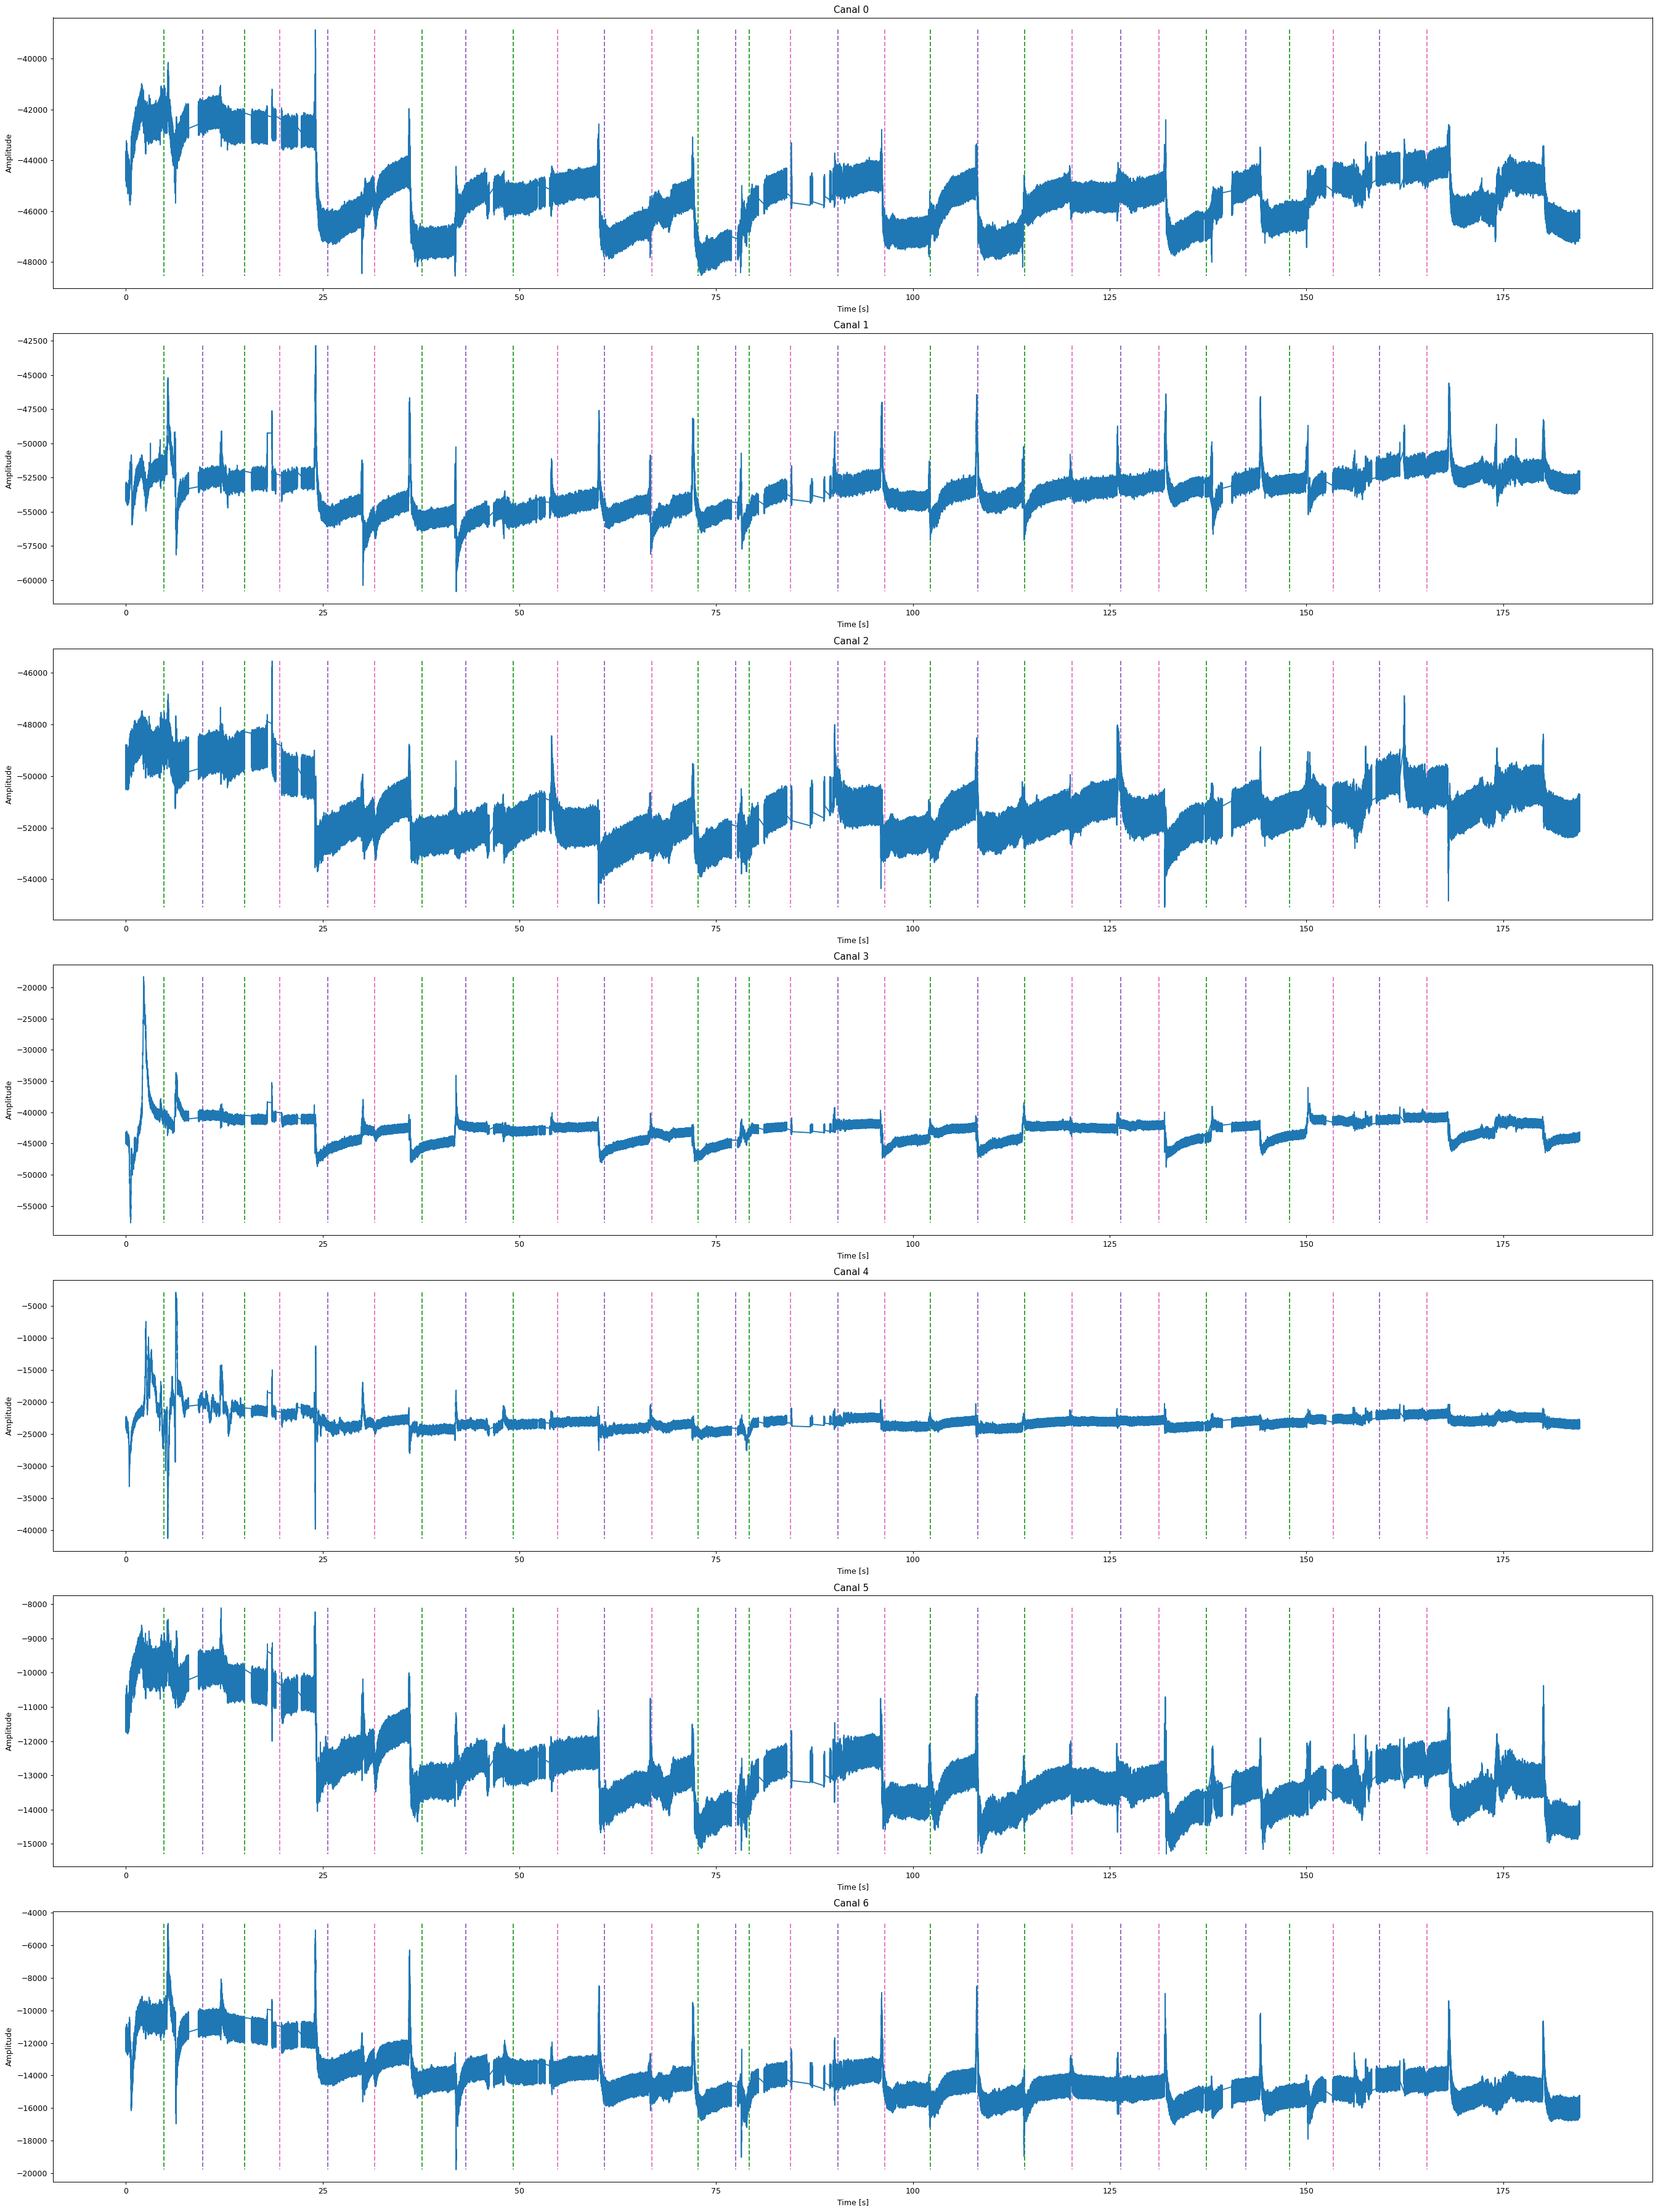

In [ ]:
fig = plt.figure(figsize=(30, 40), dpi=90)
gs=GridSpec(nrows=7, ncols=1)

ax=[0,1,2,3,4,5,6]
channels=7
for ch in range(0,channels):
  ax[ch]=fig.add_subplot(gs[ch,0])
  for i, k in enumerate(markers.keys(), start=1):
      if k.startswith('I'):
          continue
      plt.vlines(np.array(markers[k])/1000, max(data[ch]), min(data[ch]), linestyle='--', color=f'C{i}', label=k)
  plt.plot(timestamp/1000, data[ch])
  ax[ch].set_xlabel('Time [s]')
  ax[ch].set_ylabel('Amplitude')
  ax[ch].set_title('Canal %d '%ch )

fig.tight_layout()

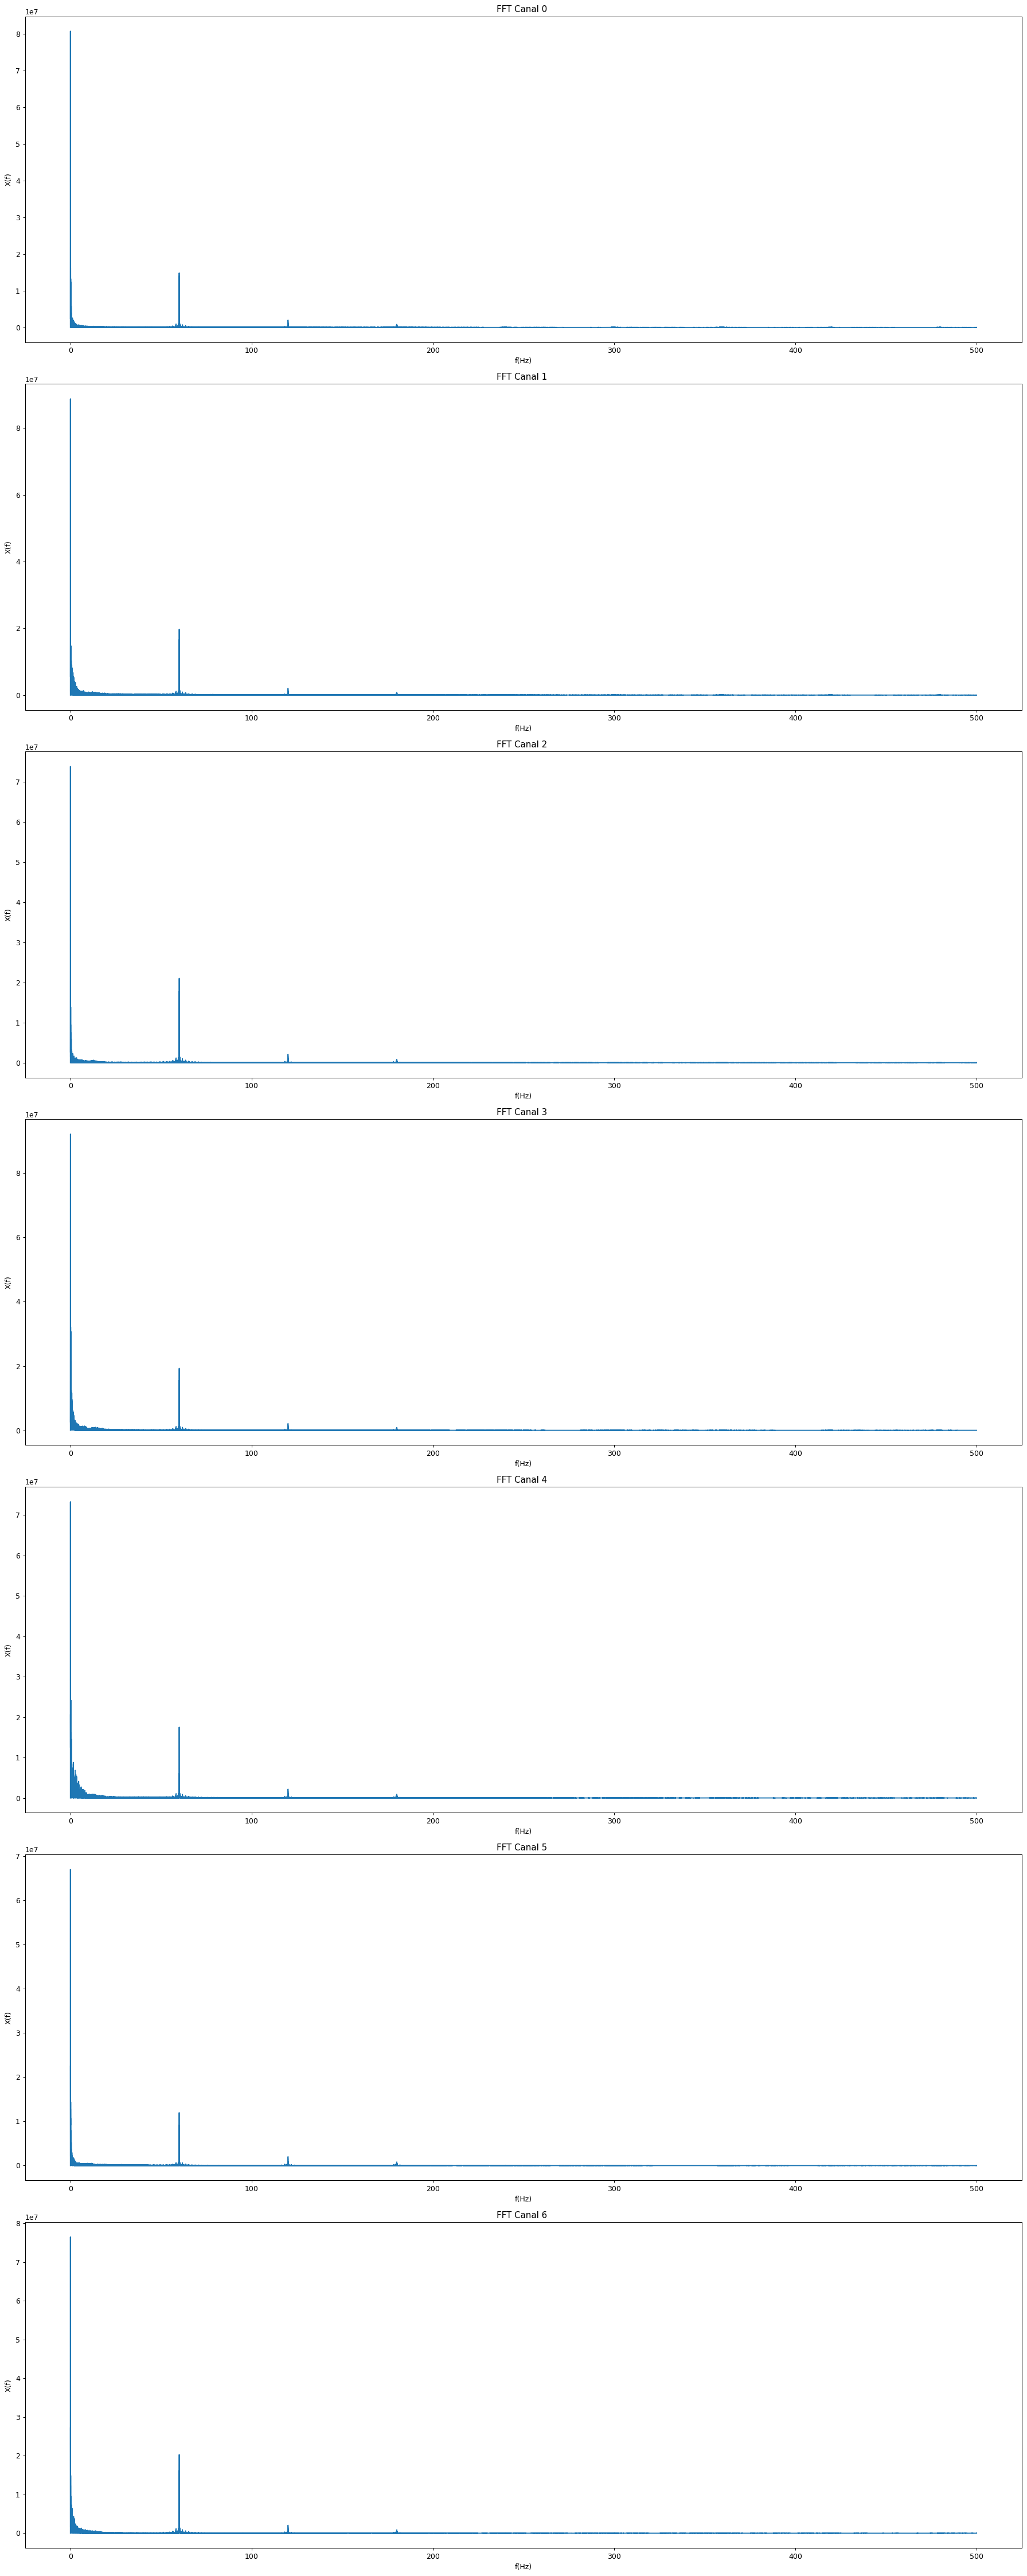

In [ ]:
from scipy.fftpack import rfft, rfftfreq


fig = plt.figure(figsize=(20, 50), dpi=90)
gs=GridSpec(nrows=7, ncols=1)

ax=[0,1,2,3,4,5,6]
channels=7
for ch in range(0,channels):
  ax[ch]=fig.add_subplot(gs[ch,0])
  X = rfft(data[ch]-data[ch].mean())
  W = rfftfreq(len(X), d=1/sample_rate)
  ax[ch].plot(W, np.abs(X))
  ax[ch].set_xlabel('f(Hz)')
  ax[ch].set_ylabel('X(f)')
  ax[ch].set_title('FFT Canal %d '%ch )

fig.tight_layout()

## Preprocesamiento

La señal se transforma de forma que podamos manipularla de forma mas fácil, se acotan valores, se normaliza, se filtra, se remueven outliers... Todo depende de la naturaleza de nuestra señal.

<font color='#b00702'>
<b>Actividad:</b> 

1. Normalizar la señal (0-1).
1. Filtrar la señal.

</font>

###Normalización

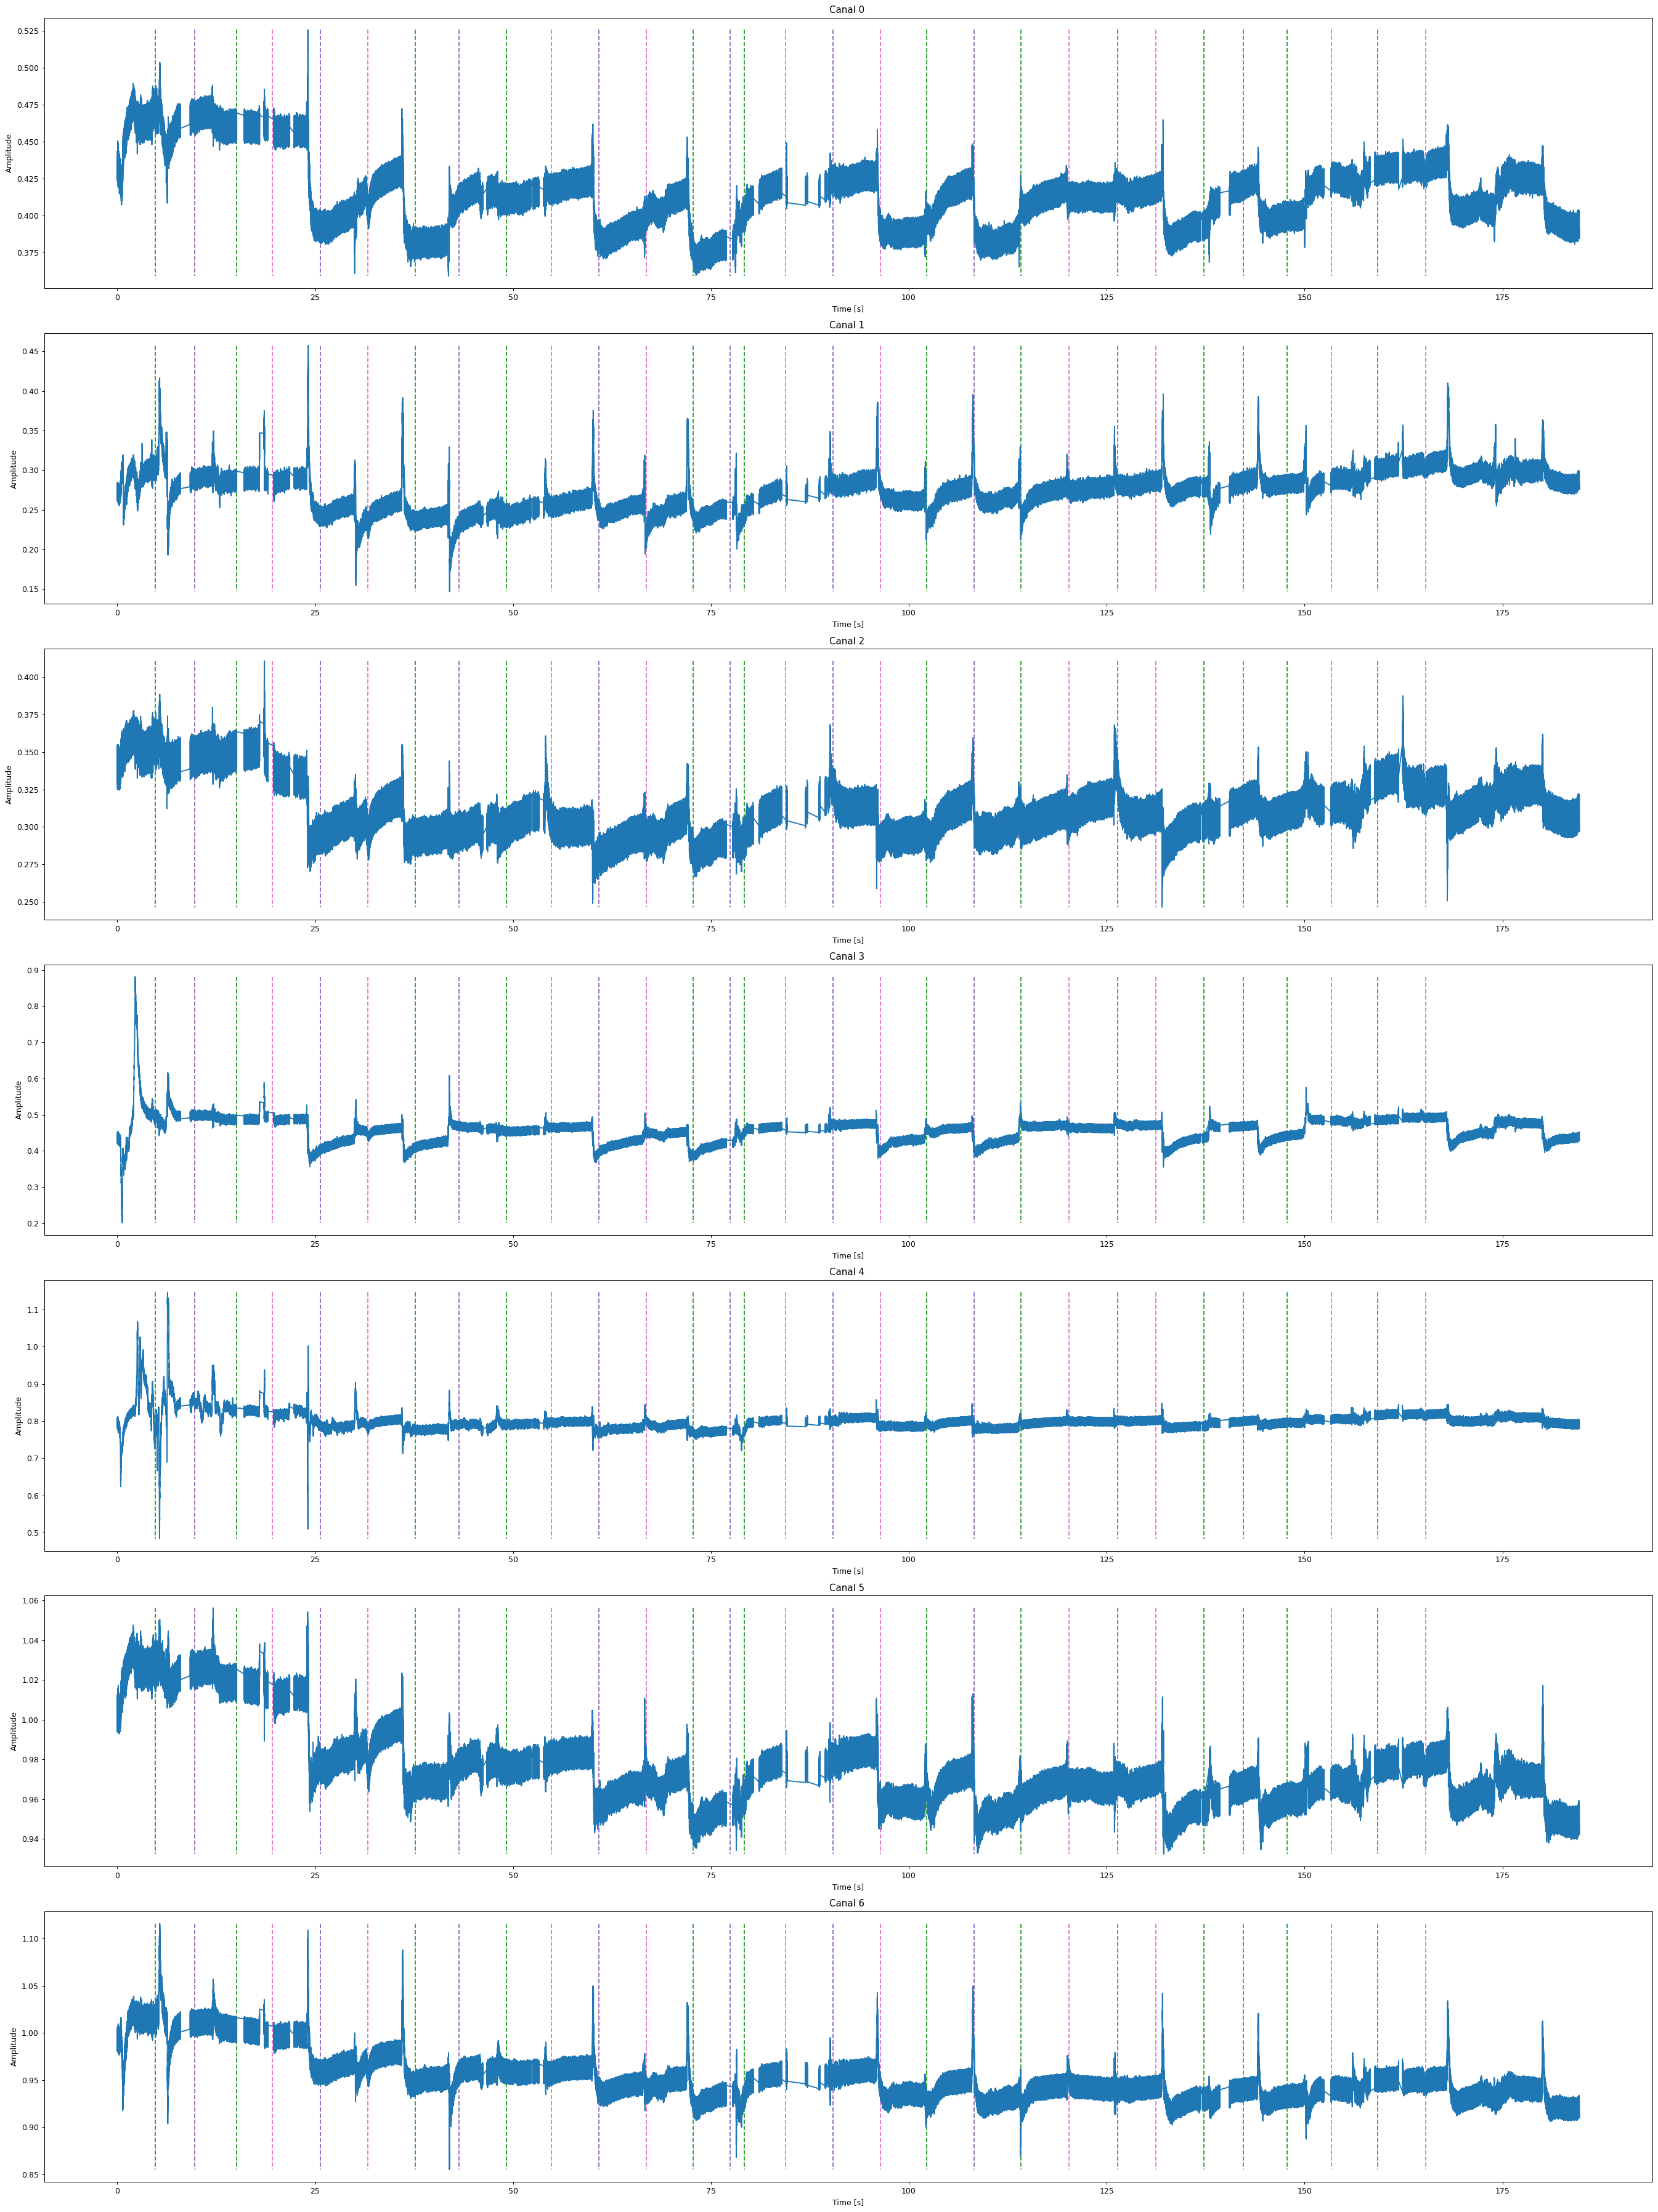

In [ ]:
fig = plt.figure(figsize=(30, 40), dpi=90)
gs=GridSpec(nrows=7, ncols=1)

ax=[0,1,2,3,4,5,6]
channels=7
data_norm=data/(np.max(data)- np.min(data))
data_norm=data_norm-2*data_norm.mean()
for ch in range(0,channels):
  ax[ch]=fig.add_subplot(gs[ch,0])
  for i, k in enumerate(markers.keys(), start=1):
      if k.startswith('I'):
          continue
      plt.vlines(np.array(markers[k])/1000, max(data_norm[ch]), min(data_norm[ch]), linestyle='--', color=f'C{i}', label=k)
  plt.plot(timestamp/1000, data_norm[ch])
  ax[ch].set_xlabel('Time [s]')
  ax[ch].set_ylabel('Amplitude')
  ax[ch].set_title('Canal %d '%ch )


fig.tight_layout()

###Filtrado

In [ ]:
from scipy import signal
b, a = signal.butter(4, 10, 'low', analog=False, fs=sample_rate)


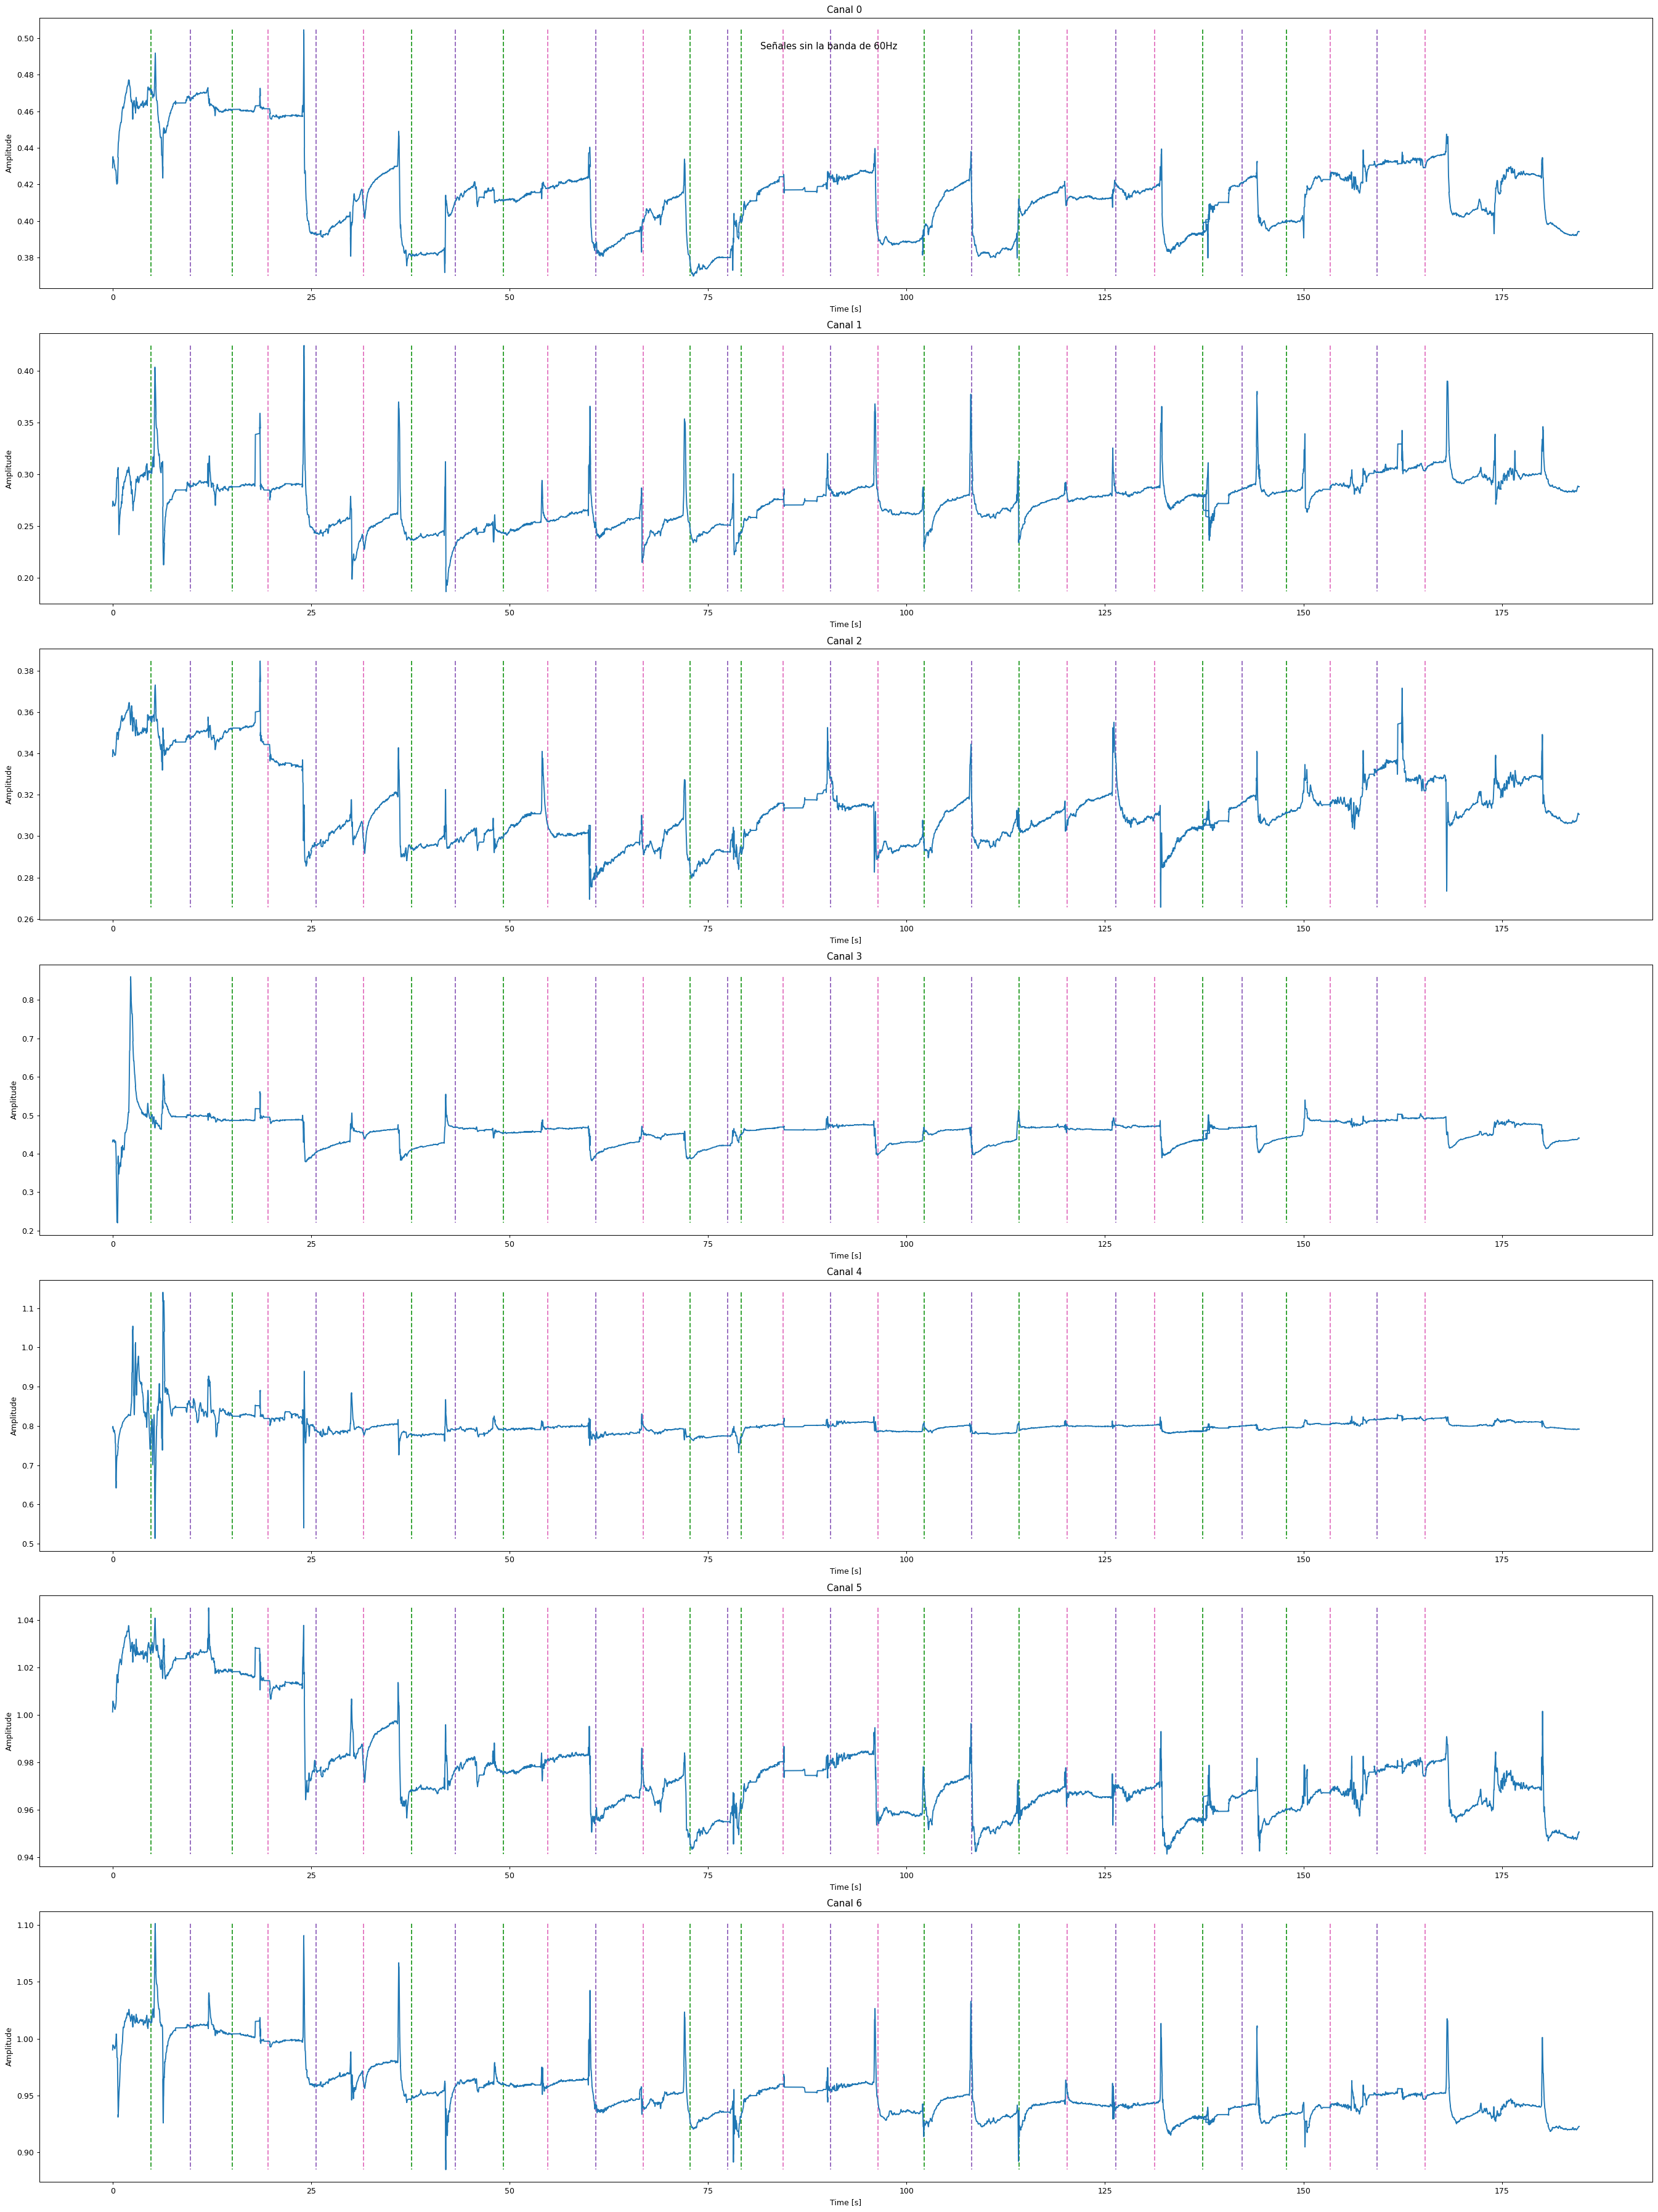

In [ ]:
fig = plt.figure(figsize=(30, 40), dpi=90)
gs=GridSpec(nrows=7, ncols=1)

ax=[0,1,2,3,4,5,6]
channels=7

data_F= data_norm.copy()
for ch in range(0,channels):
  data_F[ch]= signal.filtfilt(b, a, data_norm[ch])
  ax[ch]=fig.add_subplot(gs[ch,0])
  for i, k in enumerate(markers.keys(), start=1):
      if k.startswith('I'):
          continue
      plt.vlines(np.array(markers[k])/1000, max(data_F[ch]), min(data_F[ch]), linestyle='--', color=f'C{i}', label=k)
  plt.plot(timestamp/1000, data_F[ch])
  ax[ch].set_xlabel('Time [s]')
  ax[ch].set_ylabel('Amplitude')
  ax[ch].set_title('Canal %d '%ch )



fig.suptitle('Señales sin la banda de 60Hz')
fig.tight_layout()

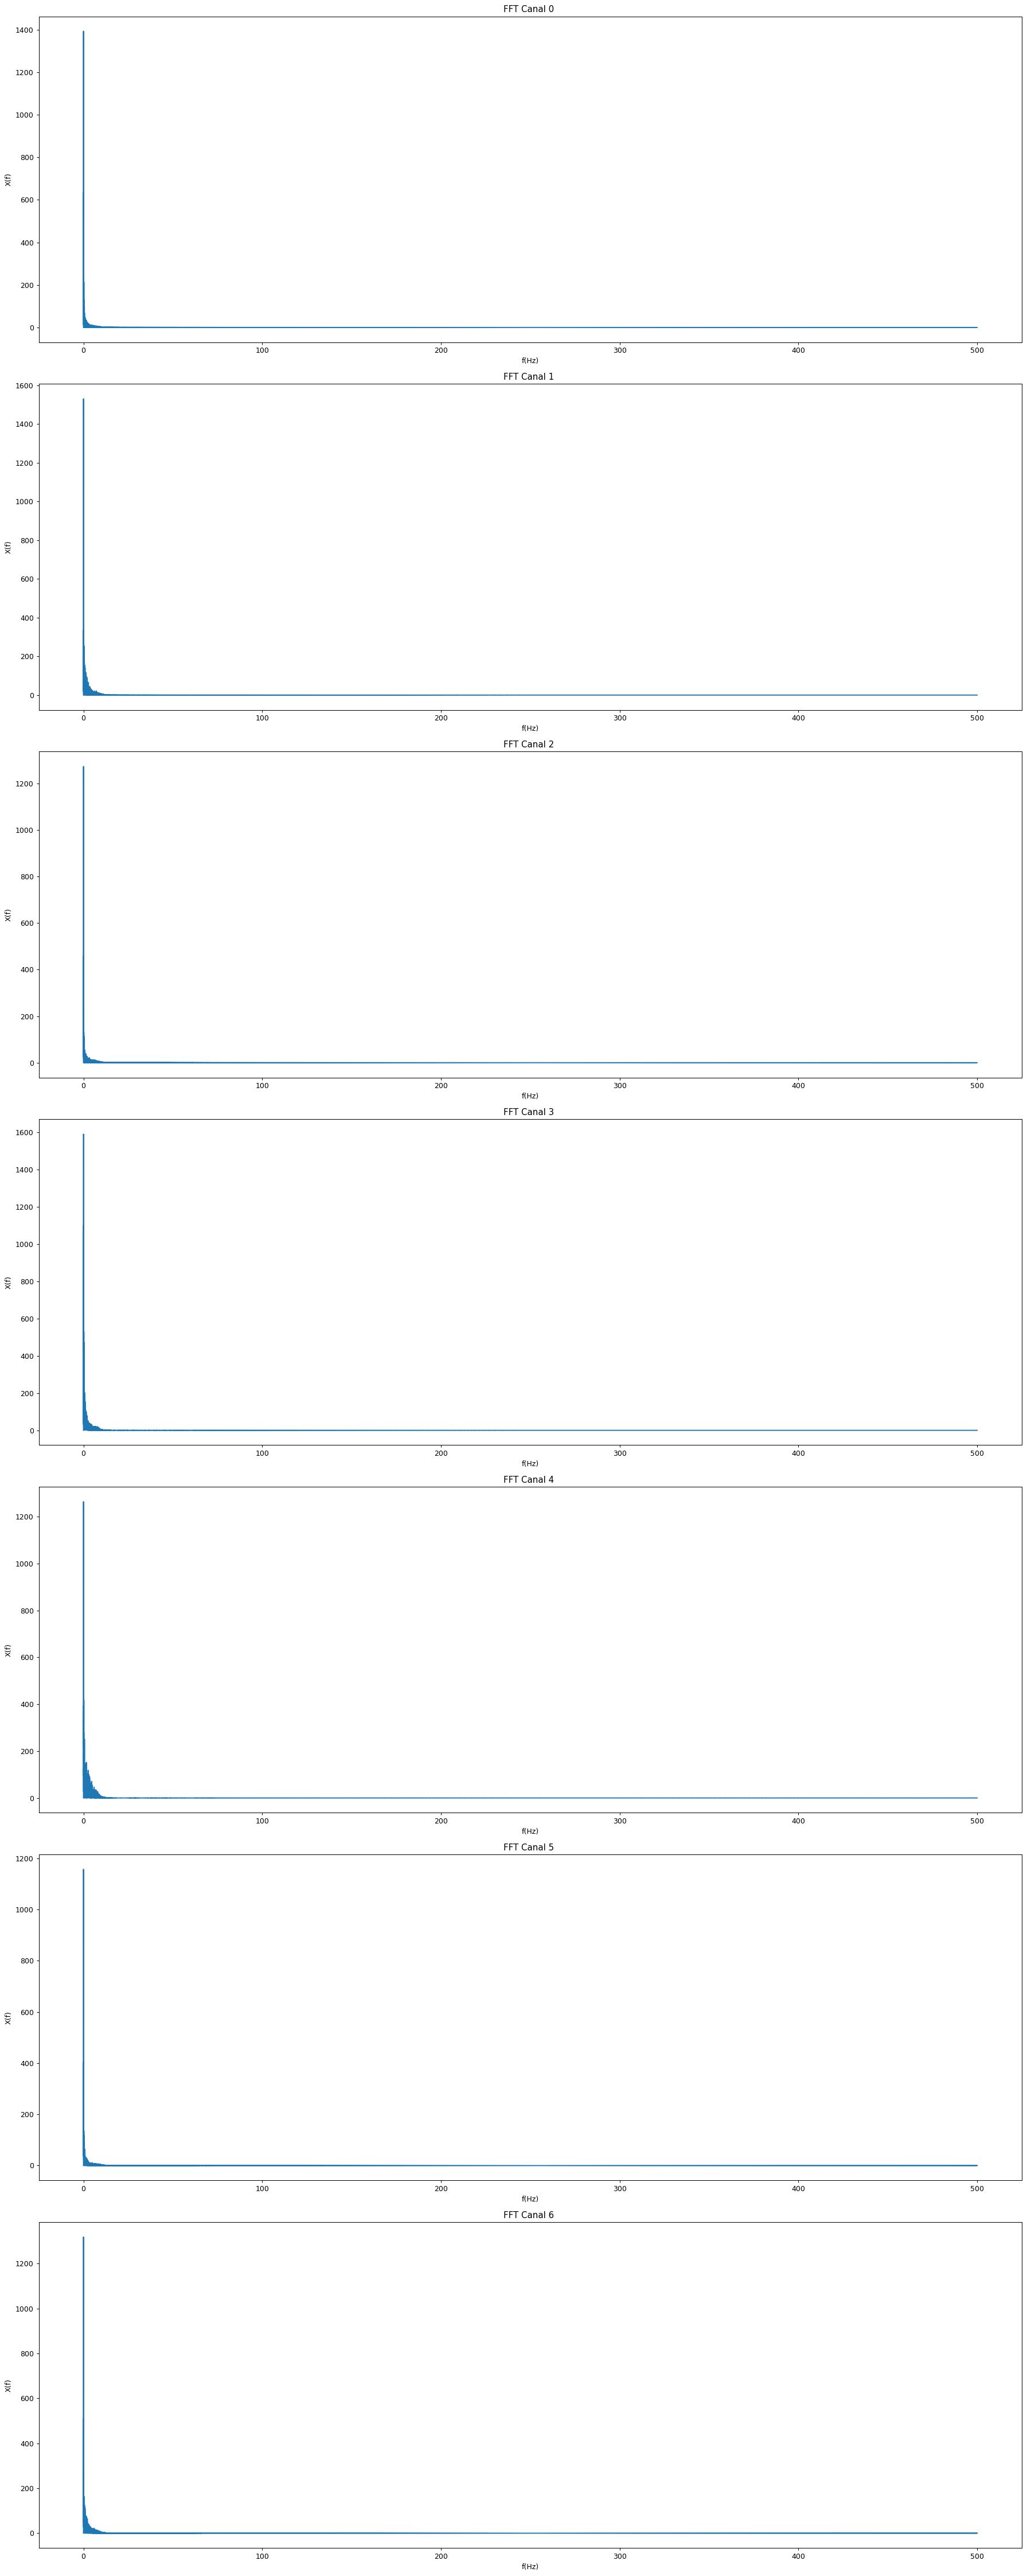

In [ ]:
from scipy.fftpack import rfft, rfftfreq


fig = plt.figure(figsize=(20, 50), dpi=90)
gs=GridSpec(nrows=7, ncols=1)

ax=[0,1,2,3,4,5,6]
channels=7
for ch in range(0,channels):
  ax[ch]=fig.add_subplot(gs[ch,0])
  X = rfft(data_F[ch]-data_F[ch].mean())
  W = rfftfreq(len(X), d=1/sample_rate)
  ax[ch].plot(W, np.abs(X))
  ax[ch].set_xlabel('f(Hz)')
  ax[ch].set_ylabel('X(f)')
  ax[ch].set_title('FFT Canal %d '%ch )

fig.tight_layout()

## Análisis por trial

<font color='#b00702'>
<b>Actividad:</b> 

1. Separar las señales en ```(trials, canales, tiempo```), con su respectivo vector de clases para cada posisión de mano final.
1. Separar las señales en ```(trials, canales, tiempo```), con su respectivo vector de clases para cada transición de posición.

</font>

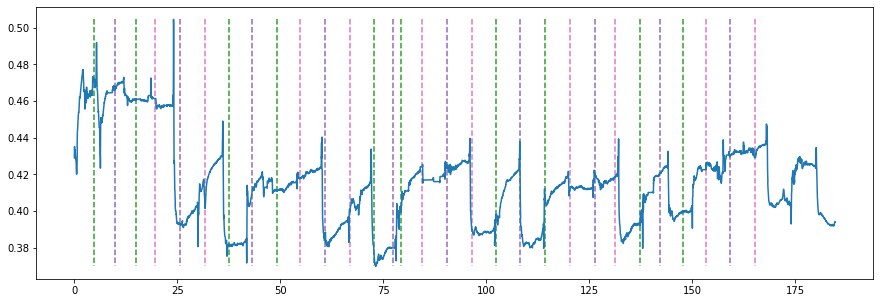

In [ ]:
plt.figure(figsize=(15,5))

for i, k in enumerate(markers.keys(), start=1):
    if k.startswith('I'):
        continue
    plt.vlines(np.array(markers[k])/1000, max(data_F[0]), min(data_F[0]), linestyle='--', color=f'C{i}', label=k)
plt.plot(timestamp/1000,data_F[0])
plt.show()

In [ ]:
x=[]
y=[]

for k in markers.keys():
  print(k)
  for i in markers[k]:
    x.append(data_F[:, i-500:i+3000])
    y.append(k)
    

I-Paper
Paper
I-Scissors
Scissors
I-Rock
Rock


In [ ]:
x = np.array(x)
x.shape

(60, 7, 3500)

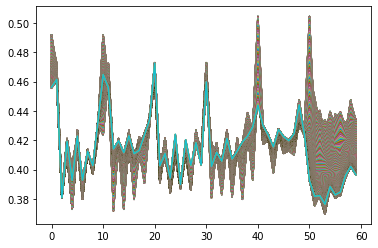

In [ ]:
plt.plot(x[:,0,:])
plt.show()

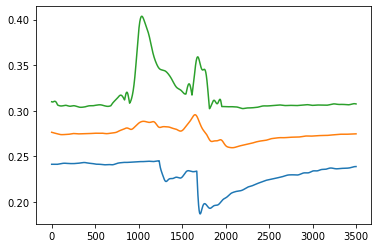

In [ ]:
y = np.array(y)
y == "Paper"

plt.plot(x[y== "Paper", 1, :].min(axis=0))
plt.plot(x[y== "Paper", 1, :].mean(axis=0))
plt.plot(x[y== "Paper", 1, :].max(axis=0))
plt.show()

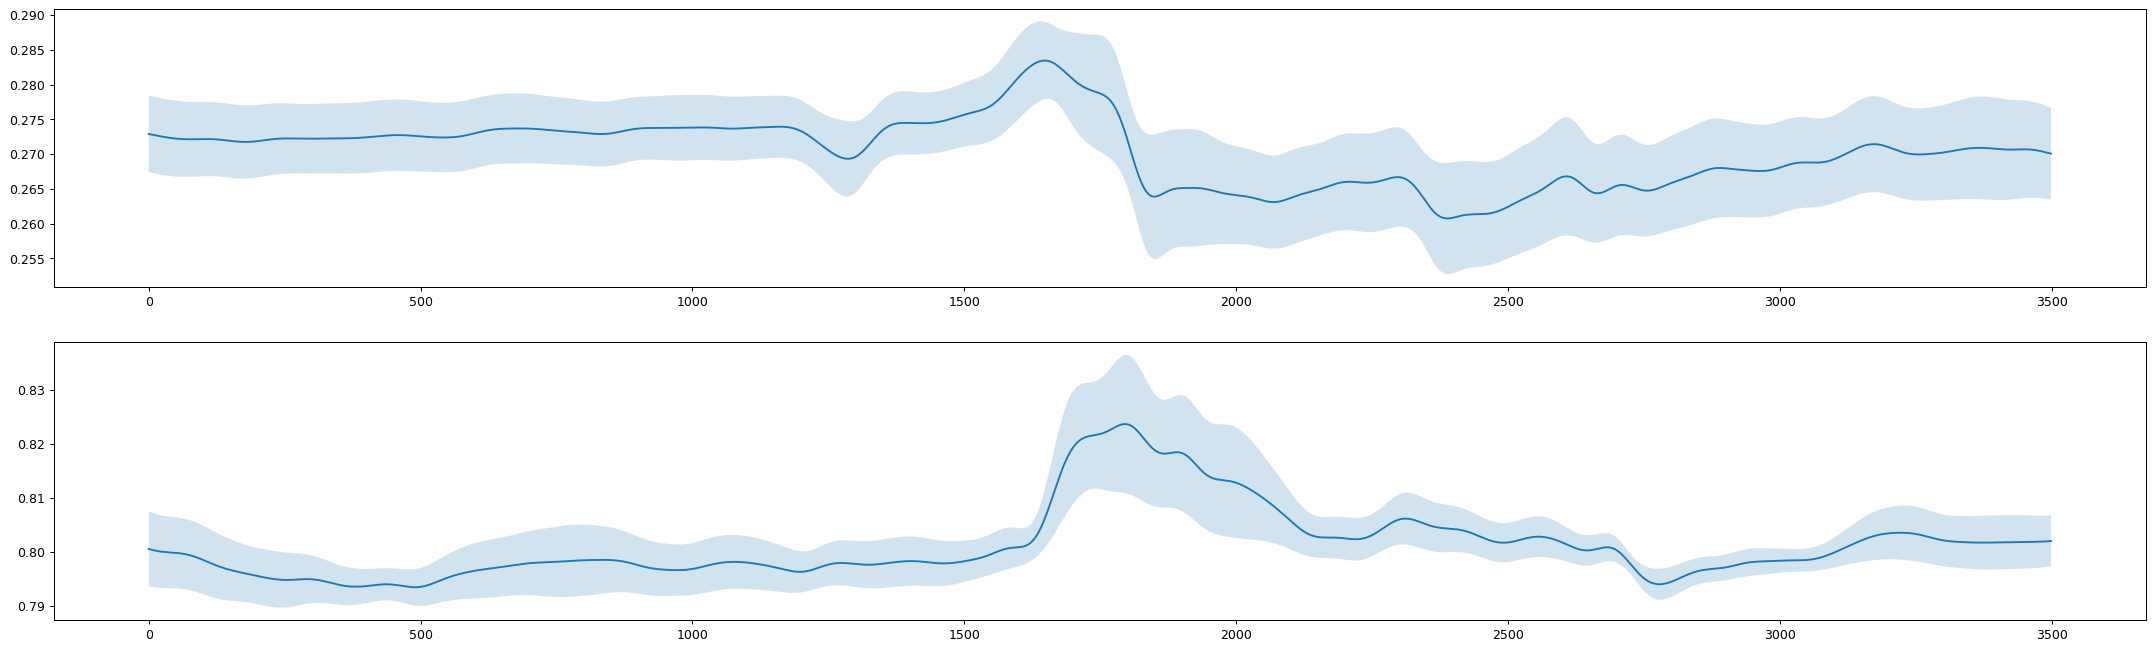

In [ ]:
plt.figure(figsize = (30,9), dpi = 90)
plt.subplot(2,1,1)
mean = x[y== "Scissors", 1, :].mean(axis=0)
std = x[y== "Scissors", 1, :].std(axis=0)
plt.plot(mean)
plt.fill_between(range(3500), mean-std*0.3, mean+std*0.3, alpha=0.2)

plt.subplot(2,1,2)
mean = x[y== "Scissors", 4, :].mean(axis=0)
std = x[y== "Scissors", 4, :].std(axis=0)
plt.plot(mean)
plt.fill_between(range(3500), mean-std*0.3, mean+std*0.3, alpha=0.2)

plt.show()

##Calcular los coeficientes de la transformada

In [ ]:
from cmath import cos, e, inf, exp, pi

In [ ]:
#Coeficientes de Fourier
N=1/sample_rate
w=2*np.pi/T
def a(n):
  return 2*np.trapz(y*cos(n*w*t),t)/N
def b(n):
  return 2*np.trapz(y*sin(n*w*t),t)/N

In [ ]:
(1/N)*x[n]*exp(-1j*k*w*n)

In [ ]:
def coefs(x,sample_rate,K):
  N=1/sample_rate
  w=2*pi/N
  a=[]
  temp=[]
  for k in range(K):
    for n in range(len(x)):
      temp.append(x[n]*exp(-1j*k*w*n))
    a.append((1/N)*sum(temp))
  return a


In [ ]:
a=coefs(data_60[0],sample_rate, len(data_60[0]))

In [ ]:
a

[(70927521.63954528+0j),
 (141855043.27909493+3.864229915748785j),
 (212782564.91864273+11.592689747246284j),
 (283710086.5581833+17.719043005469228j),
 (354637608.1977316+33.17596266846341j)]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


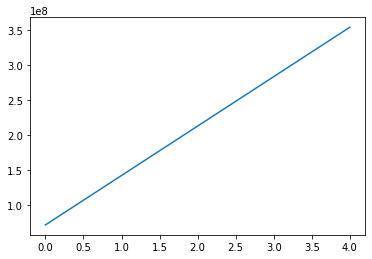

In [ ]:
plt.plot(abs(a))

#DFT

In [ ]:
def dft(x,sample_rate,K):
  N=1/sample_rate
  w=2*pi/N
  a=[]
  temp=[]
  for k in range(K):
    for n in range(len(x)):
      temp.append(x[n]*exp(-1j*k*w*n))
    a.append(sum(temp))
  return a

In [ ]:
a=dft(data_60[0],sample_rate, len(data_60[0]))

In [ ]:
plt.plot(a)